# TO DO

- assign the GPU

# First things first

Do some Python 'magic':

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import the fastai libaries:

In [ ]:
from fastai import *
from fastai.text import *

# TORCH.CUDA

https://pytorch.org/docs/stable/cuda.html#torch.cuda.current_device

Returns a bool indicating if CUDA is currently available:

In [3]:
torch.cuda.is_available()

True

Returns the number of GPUs available:

In [ ]:
torch.cuda.device_count()

Returns cublasHandle_t pointer to current cuBLAS handle:

In [ ]:
torch.cuda.current_blas_handle()

Returns the index of a currently selected device:

In [ ]:
torch.cuda.current_device()

Gets the name of a device:

In [4]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 6GB'

Returns a currently selected Stream:

In [ ]:
torch.cuda.current_stream()

Gets the cuda capability of a device:

In [ ]:
torch.cuda.get_device_capability(0)

In [ ]:
torch.cuda.set_device(0)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [6]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

GeForce GTX 1060 6GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


To move tensors to the respective device:

In [ ]:
torch.rand(10).to(device)

Or create a tensor directly on the device:

In [ ]:
torch.rand(10, device=device)

Releases all unoccupied cached memory currently held by the caching allocator so that those can be used in other GPU application and visible in nvidia-smi:

In [ ]:
torch.cuda.empty_cache()

Returns the maximum GPU memory usage by tensors in bytes for a given device:

In [ ]:
torch.cuda.max_memory_allocated(device=0)

turns the maximum GPU memory managed by the caching allocator in bytes for a given device:

In [ ]:
torch.cuda.max_memory_cached(device=0)

Returns the current GPU memory managed by the caching allocator in bytes for a given device:

In [ ]:
torch.cuda.memory_cached(device=0)

In [ ]:
torch.cuda.memory_cached(0)

In [ ]:
device

# Preparing Data

IMDB movie reviews:

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

It only contains one csv file, let's have a look at it with PANDAS

In [ ]:
df = pd.read_csv(path/'texts.csv')
df.head()

In [ ]:
df['text'][1]

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_lm.save()

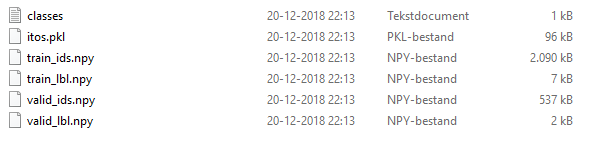

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = TextDataBunch.load(path)

# Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [ ]:
data = TextClasDataBunch.load(path)
data.show_batch()

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols:

- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

In [ ]:
data.vocab.itos[:10]

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data.train_ds[0][0]

But the underlying data is all numbers

In [ ]:
data.train_ds[0][0].data[:10]

# Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [7]:
# bs=48
bs=18

Now let's grab the full dataset for what follows.

In [8]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/train')]

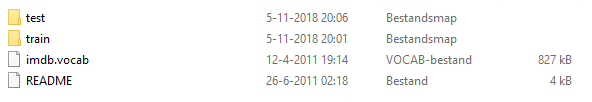

In [9]:
(path/'train').ls()

[WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/train/unsup'),
 WindowsPath('C:/Users/Johan den Hartigh/.fastai/data/imdb/train/unsupBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an unsup folder in train that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called wikitext-103, https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/ ). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [10]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [11]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [12]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj has there ever been an xxmaj angel of xxmaj death like xxup mimsy xxup farmer in xxmaj barbet xxmaj schroeder 's 1960s heroin opus ? xxmaj sort of xxmaj jean xxmaj seberg with a hypodermic . xxmaj pink xxmaj floyd score . xxmaj despite some ultimately insignificant weaknesses , a classic , shamelessly ripped off by xxmaj erich xxmaj segal / xxmaj noel xxmaj black for their inept"
1,"there to make her better and not do those things ? xxmaj there were various other parts that occurred after this , but it would just be redundant to look at them in more detail . i guess i just had a serious problem with the decision by xxmaj cassavetes to have his characters act in this way . xxmaj it simply did n't make sense . \n\n xxmaj however"
2,"( fake ) ' first ladies ' . xxmaj what have we seen the first , wrong , sequence of events for then ? \n\n xxmaj terrible choice in casting , a convoluted , messy plot and a headache - inducing directorial style . 1 / 5 . xxbos xxmaj the "" silver screen "" gets freshly polished with this beautiful film about aging happily and enjoying life 's rainbows"
3,"nicest , most considerate man alive , and his wife and biological son , all in constant conflict . i really wanted to enjoy a heartwarming story , but the only thing that made me xxup smile was when all the hate and fighting were over . xxmaj there were too many unexplained or illogical events , many of which do n't add to the story . xxmaj my wife"
4,"are at least as bad as xxmaj ed xxmaj wood 's and both men finished up their careers making porno flicks . xxmaj this film , made in the pre - porno days , manages to perhaps be the worse excuse for a film xxmaj adamson ever made -- even worse than xxmaj dracula xxup vs . xxup frankenstein ! ! xxmaj that 's because this master of the super"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [13]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


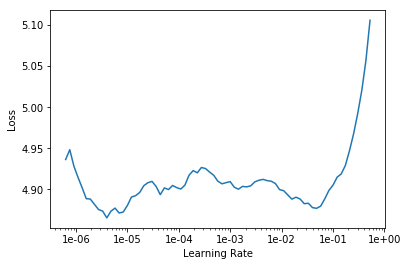

In [15]:
learn.recorder.plot(skip_end=15)

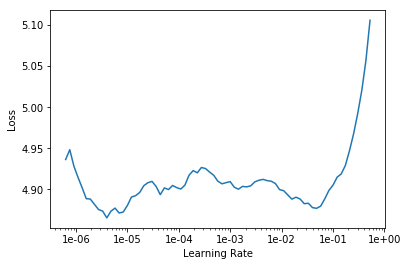

In [16]:
learn.recorder.plot(skip_end=15)

In [17]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.489606,4.295325,0.281227


In [18]:
learn.save('first')

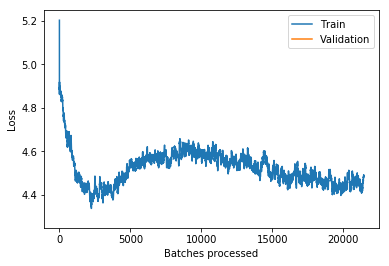

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.247649,4.137711,0.295967


In [21]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.223860,4.115462,0.298692


In [22]:
learn.save('lm_customized')

In [23]:
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60003, bias=True)
    (output_dp): RNNDropout()
  )
)

In [24]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-1/(2.6**4),1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.389503,4.318404,0.281412
2,4.572343,4.555704,0.263802


KeyboardInterrupt: 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))